In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### 准备数据

torchvision模块内置了常用的数据集和常见的模型

In [2]:
import torchvision

In [3]:
from torchvision import datasets  # 导入torchvision中的数据集
from torchvision import transforms# 导入转换数据工具的工具集

In [4]:
# transforms.ToTensor()    
#                         ①将任何类型的输入数据转换为一个Tensor,
#                         ②归一化,
#                         ③将数据化图像的channel放在第一维
# transforms.Normalize()   将任何类型的数据标准化到-1~1之间

In [5]:
transformation = transforms.Compose([ # 定义需要对数据集进行的数据转换
    transforms.ToTensor(),
    #transforms.Normalize()
])

In [6]:
## 在GPU上训练的步骤:
## 1.将模型转移到GPU
## 2.将每一个批次的训练数据转移到GPU

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# 创建Dataset
train_ds = datasets.MNIST(
                          "data/",                   # 将数据集下载，并存储到指定目录
                          train = True,              # 设定本数据集是否作为训练数据
                          transform = transformation,# 设定数据集需要做何种变换
                          download = True            # 是否将数据及下载到本地
                         )                           # 得到手写数字识别数据集MNIST
test_ds = datasets.MNIST(
                         "data/",
                         train = False,
                         transform = transformation,
                         download = True
                        )

In [9]:
# 创建DataLoader
train_dl = torch.utils.data.DataLoader(train_ds,batch_size = 64,shuffle = True)
test_dl  = torch.utils.data.DataLoader(test_ds,batch_size = 256,shuffle = False)

In [10]:
# 查看数据
imgs,label = next(iter(train_dl))

In [11]:
imgs.shape                                           # 批量图像的数字形式格式为[图像数量,通道数,高,宽] 也即 [batch,channel,,height,width]  

torch.Size([64, 1, 28, 28])

tensor(0)


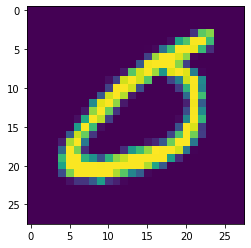

In [12]:
img = imgs[0]                                        # 取出一张图片数据 并进行图形化展示
img = img.numpy()                                    # 将图像从torch转化为numpy
img = np.squeeze(img)                                # 将多余的通道方向上的维度去掉
plt.imshow(img)                                      # 绘制图像
print(label[0])                                      # 输出改图项的正确标签

In [13]:
# 自定义绘图函数
def imshow(img):
    npimg = img.numpy()
    npimg = np.squeeze(npimg)
    plt.imshow(npimg)

tensor(0)
tensor(8)
tensor(8)
tensor(5)
tensor(7)
tensor(3)
tensor(1)
tensor(2)
tensor(0)
tensor(5)


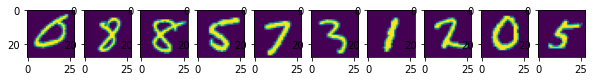

In [14]:
# 测试自定义绘图函数
plt.figure(figsize=(10,1))                            #自定义10张画布
for i,img in enumerate(imgs[:10]):                    #对数据集中的前十张图片
    plt.subplot(1,10,i+1)                             #指定在当前迭代到的位置绘制哪一张图片
    imshow(img)                                       #绘制图片
    print(label[i])                                   #按顺序输出各个图片所对应的标签   

#### 创建模型

In [15]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1   = nn.Conv2d(1,6,(5,5)) # 参数 ： 输入图像通道数 输入图像通道数(卷积核的数量) 卷积核大小 默认跨度=1 默认填充=0
        self.pool     = nn.MaxPool2d((2,2))  # 最大池化 下采样层 参数 ： 池化核大小
        self.conv_2   = nn.Conv2d(6,16,(5,5))# 这里的通道数为上一层的输出层通道数
        self.linear_1 = nn.Linear(16*4*4,256)# 16*4*4 是展平之后的长度
        self.linear_2 = nn.Linear(256,10)
    
    def forward(self,input):
        x = self.conv_1(input)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.size())             # 使用这种方式确定最后的卷积层输出数据的规模
        
        x = x.view(-1,16*4*4)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        return x                     # 这里不需要使用sigmoid函数进行二分类

In [16]:
def fit(model,trainloader,testloader,epoch):
    correct = 0       # 记录正确率
    total   = 0       # 记录训练样本总数量
    running_loss = 0
    
    for x,y in trainloader:
        x,y    = x.to(device),y.to(device)
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_acc  = correct / total # 得到整个样本的平均预测正确率
    
    test_correct      = 0       # 记录正确率
    test_total        = 0       # 记录训练样本总数量
    test_running_loss = 0
    
    with torch.no_grad():
        for x,y in trainloader:
            x,y    = x.to(device),y.to(device)
            y_pred = model(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_test_acc  = test_correct / test_total # 得到整个样本的平均预测正确率
    
    print(
            "epoch:","\t",epoch,"\t",
            "loss: ","\t",round(epoch_loss,3),"\t",
            "accuracy: ","\t",round(epoch_acc,3),"\t",
            "test_loss: ","\t",round(epoch_test_loss,3),"\t",
            "test_accuracy: ","\t",round(epoch_test_acc,3),"\t"
        )
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [17]:
model               = Model()
loss_fn             = torch.nn.CrossEntropyLoss()      # 将损失函数定义为交叉熵函数
optim               = torch.optim.Adam(model.parameters(),lr = 0.0001)
epochs              = 20

In [18]:
model(imgs)

tensor([[ 1.6262e-02, -3.1995e-02, -3.2744e-02,  2.0013e-03, -1.3548e-03,
          2.9656e-02,  7.0871e-03, -5.5339e-02,  4.7062e-02, -4.2534e-03],
        [ 3.7849e-02, -4.8487e-02, -6.9142e-02, -1.3362e-02, -6.1326e-03,
          2.1950e-02, -9.1368e-03, -3.8347e-02,  3.2254e-02, -3.8838e-02],
        [ 3.8667e-02, -5.5121e-02, -4.0561e-02,  1.8418e-02, -5.3841e-03,
          1.3829e-02, -3.6290e-02, -5.3640e-02,  4.1695e-02, -3.1165e-02],
        [ 5.1858e-02, -5.5426e-02, -2.9204e-02, -9.3798e-03, -2.4134e-03,
          2.1805e-02, -1.1561e-02, -4.9236e-02,  6.2880e-02, -4.9367e-02],
        [ 1.0756e-02, -4.3854e-02, -7.4572e-02, -3.4735e-03,  1.6263e-02,
          1.1249e-02, -1.6060e-02, -2.9074e-02,  2.9581e-02, -1.5315e-02],
        [ 5.6561e-02, -5.4340e-02, -5.2549e-02, -3.4679e-04, -3.2331e-03,
          2.0525e-02, -8.2392e-03, -4.6186e-02,  4.2307e-02, -4.3933e-02],
        [ 3.4125e-02, -5.1274e-02, -6.6972e-02, -3.1199e-02, -9.9633e-03,
         -2.1209e-03, -4.1027e-0

In [19]:
model.to(device)

Model(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear_1): Linear(in_features=256, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)

In [20]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

In [21]:
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 	 0 	 loss:  	 0.013 	 accuracy:  	 0.79 	 test_loss:  	 0.031 	 test_accuracy:  	 0.901 	
epoch: 	 1 	 loss:  	 0.004 	 accuracy:  	 0.918 	 test_loss:  	 0.021 	 test_accuracy:  	 0.932 	
epoch: 	 2 	 loss:  	 0.003 	 accuracy:  	 0.94 	 test_loss:  	 0.016 	 test_accuracy:  	 0.949 	
epoch: 	 3 	 loss:  	 0.002 	 accuracy:  	 0.955 	 test_loss:  	 0.013 	 test_accuracy:  	 0.959 	
epoch: 	 4 	 loss:  	 0.002 	 accuracy:  	 0.963 	 test_loss:  	 0.01 	 test_accuracy:  	 0.966 	
epoch: 	 5 	 loss:  	 0.002 	 accuracy:  	 0.968 	 test_loss:  	 0.009 	 test_accuracy:  	 0.969 	
epoch: 	 6 	 loss:  	 0.001 	 accuracy:  	 0.972 	 test_loss:  	 0.008 	 test_accuracy:  	 0.975 	
epoch: 	 7 	 loss:  	 0.001 	 accuracy:  	 0.976 	 test_loss:  	 0.007 	 test_accuracy:  	 0.977 	
epoch: 	 8 	 loss:  	 0.001 	 accuracy:  	 0.977 	 test_loss:  	 0.007 	 test_accuracy:  	 0.978 	
epoch: 	 9 	 loss:  	 0.001 	 accuracy:  	 0.98 	 test_loss:  	 0.006 	 test_accuracy:  	 0.981 	
epoch: 	 10 	 

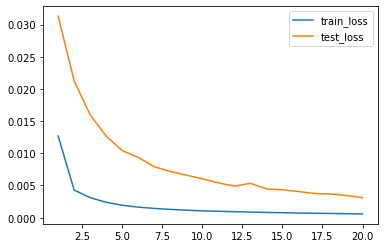

In [22]:
plt.plot(range(1,epochs+1),train_loss,label = "train_loss")
plt.plot(range(1,epochs+1),test_loss,label = "test_loss")
plt.legend()

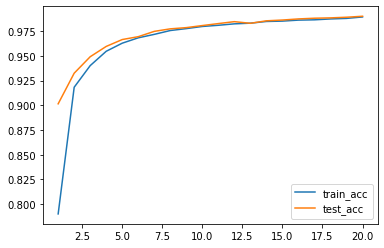

In [23]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

##### 模型的使用

In [24]:
y_pred = model(imgs.to(device))
y_pred = torch.argmax(y_pred,dim=1)

In [25]:
y_pred

tensor([0, 8, 8, 5, 7, 3, 1, 2, 0, 5, 3, 3, 8, 3, 5, 9, 7, 0, 1, 1, 6, 4, 6, 0,
        6, 4, 1, 0, 9, 0, 1, 5, 9, 2, 2, 1, 0, 8, 0, 8, 8, 5, 7, 9, 2, 8, 9, 2,
        0, 0, 4, 4, 8, 1, 6, 2, 6, 6, 8, 2, 0, 3, 5, 4], device='cuda:0')

tensor(0)
tensor(8)
tensor(8)
tensor(5)
tensor(7)
tensor(3)
tensor(1)
tensor(2)
tensor(0)
tensor(5)
tensor(3)
tensor(3)
tensor(8)
tensor(3)
tensor(5)
tensor(9)
tensor(7)
tensor(0)
tensor(1)
tensor(1)
tensor(6)
tensor(4)
tensor(6)
tensor(0)
tensor(6)
tensor(4)
tensor(1)
tensor(0)
tensor(9)
tensor(0)
tensor(1)
tensor(5)
tensor(9)
tensor(2)
tensor(2)
tensor(1)
tensor(0)
tensor(8)
tensor(0)
tensor(8)
tensor(8)
tensor(5)
tensor(7)
tensor(9)
tensor(2)
tensor(8)
tensor(9)
tensor(2)
tensor(0)
tensor(0)
tensor(4)
tensor(4)
tensor(8)
tensor(1)
tensor(6)
tensor(2)
tensor(6)
tensor(6)
tensor(8)
tensor(2)
tensor(0)
tensor(3)
tensor(5)
tensor(4)


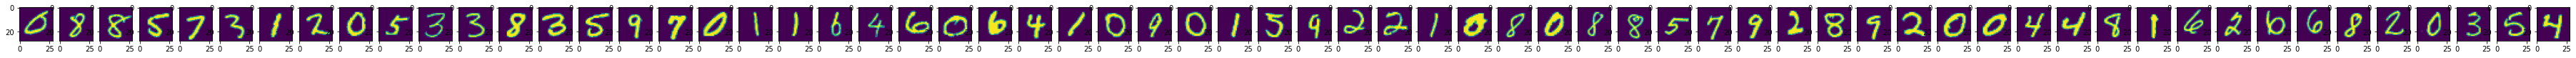

In [26]:
plt.figure(figsize=(64,1))                            #自定义10张画布
for i,img in enumerate(imgs[:64]):                    #对数据集中的前十张图片
    plt.subplot(1,64,i+1)                             #指定在当前迭代到的位置绘制哪一张图片
    imshow(img)                                       #绘制图片
    print(label[i])                                   #按顺序输出各个图片所对应的标签   